In [1]:
import torch
from diffusers import LatentEditDiffusionPipeline
from PIL import Image

2023-02-07 13:21:00.451800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 13:21:01.211133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-07 13:21:01.211227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [3]:
device='cuda:2'
pipe = LatentEditDiffusionPipeline.from_pretrained(
    "/workspace/StableDiff/models/stable-diffusion-v1-5/",
    safety_checker=None,
    ).to(device)
gen = torch.Generator(device=device)

You have passed `None` for safety_checker to disable its functionality in <class 'diffusers.pipelines.latent_edit.pipeline_latent_edit_diffusion.LatentEditDiffusionPipeline'>. Note that this might lead to problems when using <class 'diffusers.pipelines.latent_edit.pipeline_latent_edit_diffusion.LatentEditDiffusionPipeline'> and is not recommended.
/opt/conda/lib/python3.8/site-packages/diffusers/pipelines/latent_edit/pipeline_latent_edit_diffusion.py:79: UserWarning: You have disabled the safety checker for <class 'diffusers.pipelines.latent_edit.pipeline_latent_edit_diffusion.LatentEditDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network be

In [4]:
def image_grid(imgs, rows, cols, spacing = 20):
    assert len(imgs) == rows * cols
    
    w, h = imgs[0].size
    
    grid = Image.new('RGB', size=(cols * w + (cols-1)*spacing, rows * h + (rows-1)*spacing ), color='white')
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=( i // rows * (w+spacing), i % rows * (h+spacing)))
    return grid

In [5]:
prompt = 'A photo of the face of a firefighter'
# input image
seed = 42
gen.manual_seed(seed)
out = pipe(prompt=prompt, generator=gen, num_images_per_prompt=5, guidance_scale=7)
images = out.images

  0%|          | 0/51 [00:00<?, ?it/s]

In [6]:
edit = ['male person', 'female person']
#edit = edit[::-1]

# with edit
gen.manual_seed(seed)
out = pipe(prompt=prompt, generator=gen, num_images_per_prompt=5, guidance_scale=7,
           editing_prompt=edit,       # Concepts to apply 
           reverse_editing_direction=[True,False], # Direction of guidance i.e. increase cars, decrease crowd, and add sunset
           edit_warmup_steps=[15,15], # Warmup period for each concept
           edit_guidance_scale=[3,3], # Guidance scale for each concept
           edit_threshold=[0.90,0.90], # Threshold for each concept. Note that positive guidance needs negative thresholds and vice versa
           edit_momentum_scale=0.5, # Momentum scale that will be added to the latent guidance
           edit_beta1=0.6, # Momentum beta
           edit_weights=[1,1] # Weights of the individual concepts against each other
          )
images_edited = out.images

  0%|          | 0/51 [00:00<?, ?it/s]

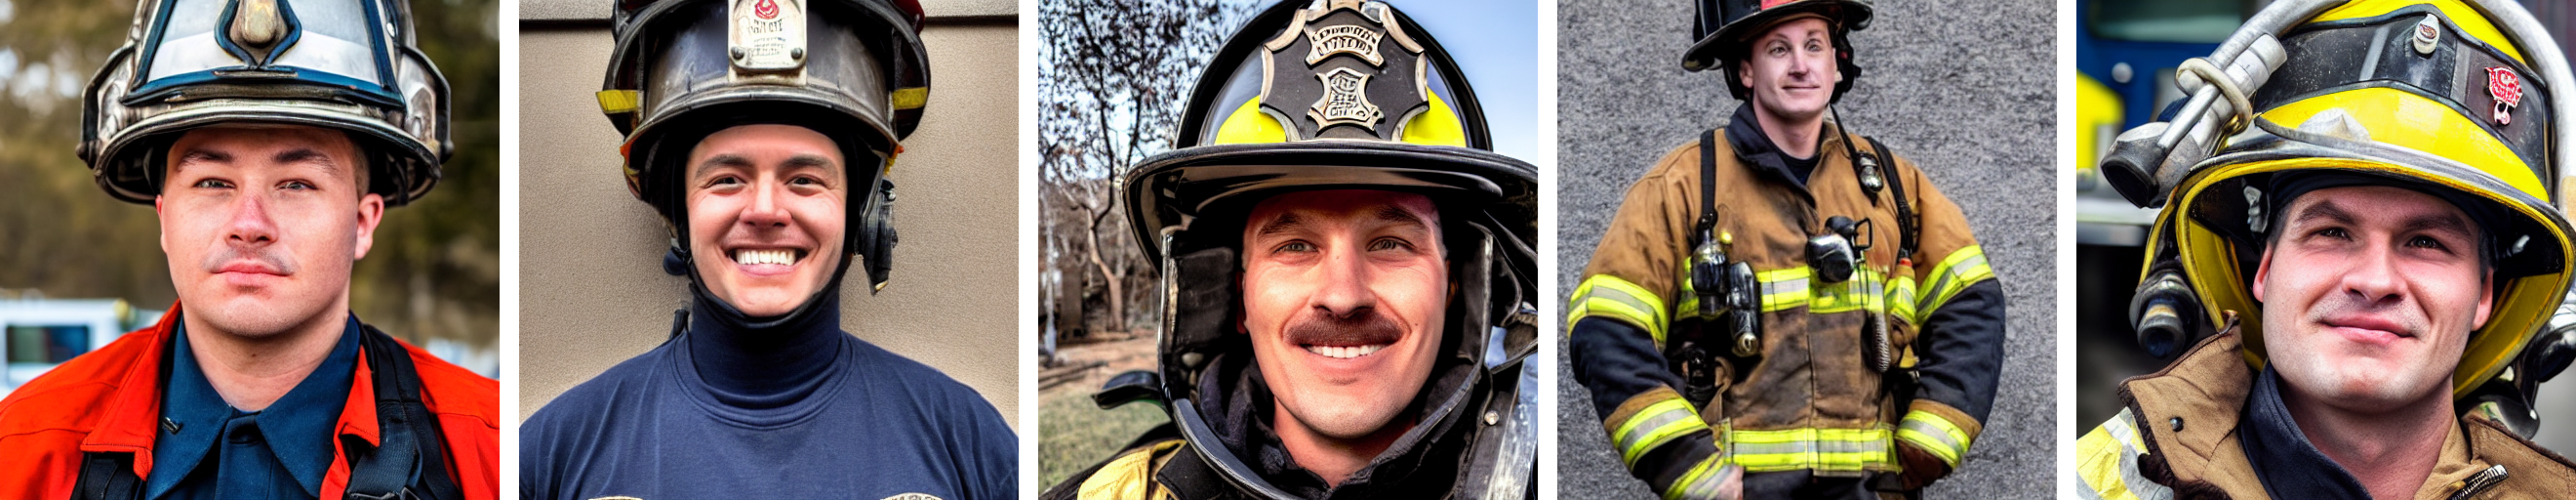

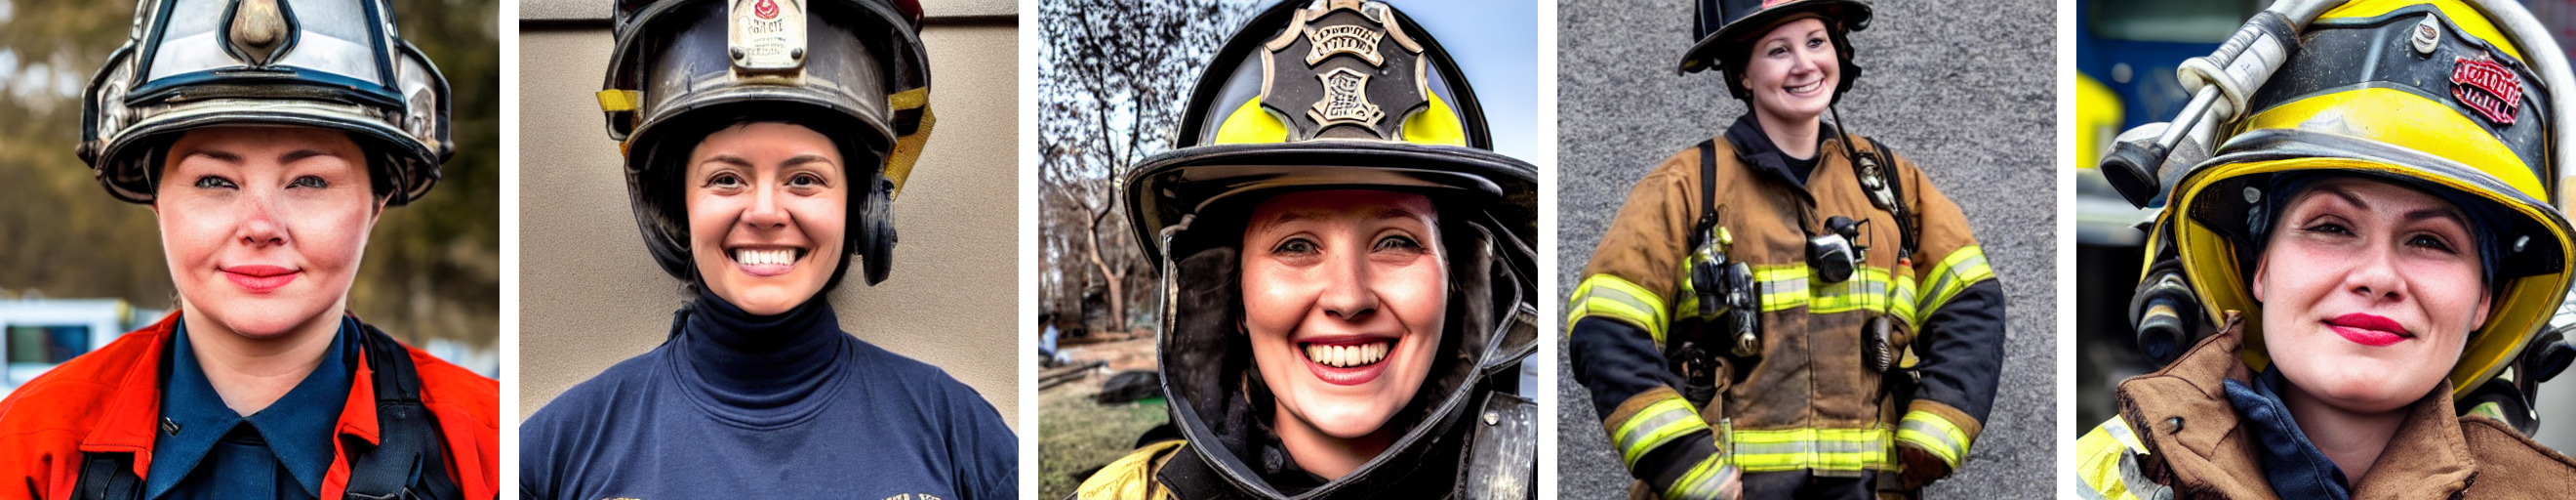

In [7]:
display(image_grid(images, 1, len(images)))
display(image_grid(images_edited, 1, len(images)))